In [8]:
import numpy as np
import networkx as nx
import EoN
import matplotlib.pyplot as plt
import csv, random, pdb, sys
from IPython.core.debugger import set_trace
import copy
import pickle as pkl

In [9]:
sys.path.insert(0, '../lib/')

In [10]:
from util import *
from graph_utils import *

In [11]:
graph_file = '../data/household_undirected_albe_1.90.txt'
G = read_graph(graph_file)

len(G)

131219

In [12]:
import pandas as pd

df = pd.read_csv('../data/Albe_demographics.csv')
df['pid'] = df['pid'].astype(str)
attrs = df.set_index('pid').to_dict('index')
nx.set_node_attributes(G, attrs)


In [13]:
hh_size = nx.get_node_attributes(G,'hh_size')
hh_income = nx.get_node_attributes(G,'hh_income')

c = [i for i in hh_income if hh_income[i] == 0]
print(len(c))

lowest = 10000
for i in hh_income:
    if hh_income[i] < lowest:
        hh_income[i] = lowest

1595


In [ ]:
if __name__ == '__main__':
### run for a fixed network and fixed alpha
##########################################

    np.random.seed(0)

    T = 10
    epsilon = 0.001
    alphavals = np.arange(1e5,1e6,1e5)
    num_times = 10

    n = len(G)
    p = 0.3
    
    raw_data = []
    exp_inf_list = []
    exp_inf_std = []
    n_vacc_size = []
    xlist_alpha = {}
    ts = {}
    for alpha in alphavals:
        zs = []
        vacc_size = []
        xlist = []
        ts[alpha] = []
        
        print("alpha: ", alpha)

        for i in range(num_times):
            x = {}
            Cvacc = {}
            Cinf = {};
            
            for u in G.nodes():
                x[u] = np.random.randint(0, 2)
                Cinf[u] = 1; 
                Cvacc[u] = Cinf[u]*float(alpha)*hh_size[u]/(n*hh_income[u])
                
            x, nviol, t = best_response_v2(G, Cvacc, Cinf, x, T, p, epsilon)

            if(nviol == 0):
                
                ts[alpha].append(t)
                
                z = exp_infsize(G, x, p)
                zs.append(z)
                
                vaccinated = len([i for i in x if x[i] == 1])
                vacc_size.append(vaccinated)
                xlist.append(x)

        n_vacc_size.append(vacc_size)
        xlist_alpha[alpha] = xlist
        
        zs = np.array(zs)
        exp_inf_list.append(zs.mean())
        exp_inf_std.append(zs.std())
    
    n_vacc_size = np.array(n_vacc_size)


alpha:  100000.0
init comp
degree done
connected components done
end init comp
init comp
degree done
connected components done
end init comp
init comp
degree done
connected components done
end init comp
init comp
degree done
connected components done
end init comp
init comp
degree done
connected components done
end init comp
init comp
degree done
connected components done
end init comp
init comp
degree done
connected components done
end init comp
init comp
degree done
connected components done
end init comp
init comp
degree done
connected components done
end init comp
init comp
degree done
connected components done
end init comp
alpha:  200000.0
init comp
degree done
connected components done
end init comp
init comp
degree done
connected components done
end init comp
init comp
degree done
connected components done
end init comp
init comp
degree done
connected components done
end init comp
init comp
degree done
connected components done
end init comp
init comp
degree done
connected comp

In [28]:
def vaccinated_boxplot(attribute_name):
    attribute = nx.get_node_attributes(G, attribute_name)
    data = []
    for alpha in alphavals:
        vaccinated = set()
        for x in xlist_alpha[alpha]:
            for k in x:
                if x[k] == 1:
                    vaccinated.add(k)
        l = [attribute[i] for i in vaccinated]
    
        data.append(l)
        
    data.append(list(attribute.values()))
    labels = list(alphavals)
    labels.append('whole')
    box = plt.boxplot(data, labels=labels)
    plt.xlabel('alpha')
    plt.ylabel(attribute_name)
    plt.savefig('vaccinated nodes-'+attribute_name)
    plt.show()

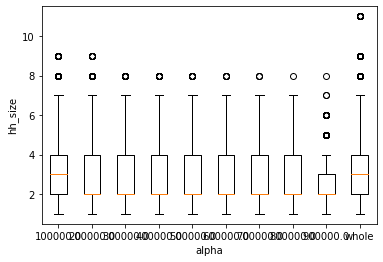

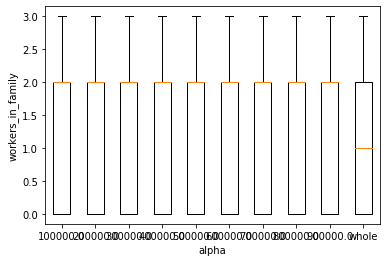

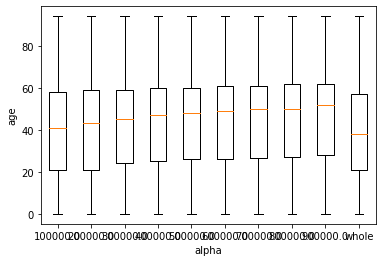

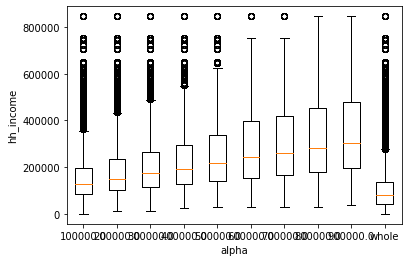

In [29]:
plt.figsize()
vaccinated_boxplot('hh_size')
vaccinated_boxplot('workers_in_family')
vaccinated_boxplot('age')
vaccinated_boxplot('hh_income')

In [ ]:
print(exp_inf_list)
print(exp_inf_std)

In [ ]:
z4 = exp_inf_list
z4std = exp_inf_std

In [ ]:
print(n_vacc_size)

In [ ]:
n_num_vacc_list = np.array(n_vacc_size)
vacc_mean = n_num_vacc_list.mean(axis = 1)
vacc_std = n_num_vacc_list.std(axis = 1)

print(list(vacc_mean))
print(list(vacc_std))

In [ ]:
k = np.array(vacc_mean).astype(int)
zs, topk_list =  get_topk_exp_infsize(G, k, p) ## sorted by alpha
jaccard_mean, jaccard_std = plot_jaccard(alphavals, xlist_alpha, topk_list)

In [ ]:
legend = ['Best-response NE', 'Topk Nodes']
plt.plot(alphavals, z4, 'o-')
plt.plot(alphavals, zs, 'o-')
plt.xlabel(r'$\alpha$')
plt.ylabel('E[#inf]')
plt.legend(legend)
plt.savefig('2_3_p4.pdf')

In [ ]:
z = [z4]
zstd = [z4std]
legend = ['p = ' + str('%0.2f'%i) for i in [0.4]]
for y, ystd in zip(z,zstd):
    plt.errorbar(alphavals, y, ystd, fmt = 'o-')
plt.xlabel(r'$\alpha$')
plt.ylabel('E[#inf]')
plt.legend(legend)
plt.show()

In [ ]:
z = [z4]
zstd = [z4std]
legend = ['p = ' + str('%0.2f'%i) for i in [0.4]]
plt.errorbar(alphavals, vacc_mean, vacc_std, fmt='o-')
plt.xlabel(r'$\alpha$')
plt.ylabel('#vacc')
plt.legend(legend)
plt.show()

In [ ]:
max([G.degree(v) for v in G.nodes()])

In [ ]:
compare_degree(G, 'whole graph')
compare_cc(G, 'whole graph')

In [ ]:
for alpha in alphavals:
    v = set(get_provax(xlist_alpha[alpha][0]))
    s = G.subgraph(v)

    compare_degree(s, 'vaccinated nodes alpha: ' + str(alpha))
    compare_cc(s, 'vaccinated nodes alpha: ' + str(alpha))

In [36]:
for alpha in alphavals:
    dmean =  np.array([dic.values() for dic in xlist_alpha[alpha] ] ).mean()
    dstd = np.array([dic.values() for dic in xlist_alpha[alpha] ] ).std()

plt.errorbar(alphavals, dmean, dstd)

TypeError: unsupported operand type(s) for +: 'dict_values' and 'dict_values'